In [422]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import betareg

import importlib

In [423]:
importlib.reload(betareg)

<module 'betareg' from 'c:\\Users\\1king\\Desktop\\University\\Logistic Regression\\Project\\betareg.py'>

In [ ]:
nominal_df = pd.read_csv("nominal_expenditures.csv")
normalized_df = pd.read_csv("normalized_food_expenditures.csv")
constant_df = pd.read_csv("constant_dollar_expenditures.csv")
monthly_df=pd.read_csv("monthly_sales.csv")

cpi_past_df = pd.read_csv("historicalcpi.csv")
cpi_new_df = pd.read_csv("CPIForecast.csv")
# nominal_expenditures_no_taxes_tips = pd.read_csv("nominal_expenditures_no_taxes_tips.csv")
# constant_dollar_expenditures_no_taxes_tips =pd.read_csv("constant_dollar_expenditures_no_taxes_tips.csv")
# food_expenditures_source_funds=pd.read_csv("food_expenditures_source_funds.csv")
# monthly_sales_by_outlet=pd.read_csv("monthly_sales by outlet.csv")

monthly_df = monthly_df[monthly_df['Year'] < 2024]
wage_info = pd.read_csv("LES1252881600Q.csv")
wage_info["Median usual weekly real earnings"] = wage_info["LES1252881600Q"]
wage_info = wage_info.drop(["LES1252881600Q"], axis=1)

In [3]:
cpi_past_df = cpi_past_df[
    (cpi_past_df['Year'] >= 1997) & (cpi_past_df['Year'] <= 2021) &
    (cpi_past_df['Consumer Price Index item'].isin(['All food', 'Food at home', 'Food away from home']))
]

# Filter for annual data (2022–2023)
cpi_new_df = cpi_new_df[
    (cpi_new_df['Attribute'].isin(['Annual 2022', 'Annual 2023'])) &
    (cpi_new_df['Top-level'] == 'All food') &
    (cpi_new_df['Aggregate'].isin(['', 'Food at home', 'Food away from home']) | cpi_new_df['Aggregate'].isna())
]

# Map columns
cpi_new_df = cpi_new_df.rename(columns={'Value': 'Percent change'})
cpi_new_df['Year'] = cpi_new_df['Attribute'].str.extract(r'(\d{4})').astype(int)
cpi_new_df['Consumer Price Index item'] = cpi_new_df['Top-level']
cpi_new_df.loc[cpi_new_df['Aggregate'].notna() & (cpi_new_df['Aggregate'] != ''), 'Consumer Price Index item'] = cpi_new_df['Aggregate']
cpi_new_df = cpi_new_df[['Consumer Price Index item', 'Year', 'Percent change']]

# Merge CPI
cpi_df = pd.concat([cpi_past_df, cpi_new_df], ignore_index=True)
cpi_df = cpi_df.drop_duplicates(subset=['Year', 'Consumer Price Index item'], keep='first')

cpi_df = cpi_df.pivot(index='Year', columns='Consumer Price Index item', values='Percent change').reset_index()
cpi_df.columns = ['Year', 'CPI_All_food', 'CPI_Food_at_home', 'CPI_Food_away_from_home']


# print(cpi_df.tail())

In [27]:
merged_df = nominal_df.merge(normalized_df, on='Year', how='inner')
merged_df = merged_df.merge(constant_df, on='Year', how='inner', suffixes=('_nominal', '_constant'))
merged_df = merged_df.merge(cpi_df, on='Year', how='inner')
merged_df["Median usual weekly real earnings"] = wage_info["Median usual weekly real earnings"]

print(merged_df.shape)

(27, 78)


In [28]:
numerical_cols = [col for col in merged_df.columns if col != 'Year']
for col in numerical_cols:
    if merged_df[col].dtype == 'object':  
        merged_df[col] = pd.to_numeric(merged_df[col].str.replace(',', ''), errors='coerce')

numerical_cols_monthly = [col for col in monthly_df.columns if col not in ['Year', 'Month']]
for col in numerical_cols_monthly:
    if monthly_df[col].dtype == 'object':
        monthly_df[col] = pd.to_numeric(monthly_df[col].str.replace(',', ''), errors='coerce')

print(merged_df[numerical_cols].dtypes)
print(merged_df[numerical_cols].isna().sum())

print("\nData types in monthly_df after conversion:")
print(monthly_df.dtypes)
print(monthly_df.isna().sum())

Grocery stores sales million nominal U.S. dollars with taxes and tips                           float64
Convenience stores sales million nominal U.S. dollars with taxes and tips                       float64
Other food stores sales million nominal U.S. dollars with taxes and tips                        float64
Warehouse clubs and supercenters sales million nominal U.S. dollars with taxes and tips         float64
Other stores and foodservice sales million nominal U.S. dollars with taxes and tips             float64
                                                                                                 ...   
Total alcohol away from home sales million constant 1988 U.S. dollars without taxes and tips    float64
CPI_All_food                                                                                    float64
CPI_Food_at_home                                                                                float64
CPI_Food_away_from_home                                         

In [29]:
monthly_df.columns

Index(['Year', 'Month',
       'Food at home sales million nominal U.S. dollars with taxes and tips',
       'Food away from home sales million nominal U.S. dollars with taxes and tips',
       'Total food sales million nominal U.S. dollars with taxes and tips',
       'Food at home sales million constant 1988 U.S. dollars with taxes and tips',
       'Food away from home sales million constant 1988 U.S. dollars with taxes and tips',
       'Total food sales million constant 1988 U.S. dollars with taxes and tips'],
      dtype='object')

In [30]:
monthly_annual_df = monthly_df.groupby('Year')[numerical_cols_monthly].sum().reset_index()

print(monthly_annual_df.shape)


(27, 7)


## Rename column name (too long)

In [31]:
rename_dict = {
    'Grocery stores sales million nominal U.S. dollars with taxes and tips': 'Grocery_Sales_Nominal',
    'Convenience stores sales million nominal U.S. dollars with taxes and tips': 'Convenience_Sales_Nominal',
    'Other food stores sales million nominal U.S. dollars with taxes and tips': 'Other_Food_Stores_Sales_Nominal',
    'Warehouse clubs and supercenters sales million nominal U.S. dollars with taxes and tips': 'Warehouse_Sales_Nominal',
    'Other stores and foodservice sales million nominal U.S. dollars with taxes and tips': 'Other_Stores_Sales_Nominal',
    'Mail order and home delivery sales million nominal U.S. dollars with taxes and tips': 'Mail_Order_Sales_Nominal',
    'Direct selling by farmers, manufacturers, and wholesalers sales million nominal U.S. dollars with taxes and tips': 'Direct_Selling_Sales_Nominal',
    'Home production and donations sales million nominal U.S. dollars with taxes and tips': 'Home_Production_Sales_Nominal',
    'Total food at home sales million nominal U.S. dollars with taxes and tips': 'Total_Food_At_Home_Sales_Nominal',
    'Full-service restaurants sales million nominal U.S. dollars with taxes and tips': 'Full_Service_Restaurants_Sales_Nominal',
    'Limited-service restaurants sales million nominal U.S. dollars with taxes and tips': 'Limited_Service_Restaurants_Sales_Nominal',
    'Drinking places sales million nominal U.S. dollars with taxes and tips': 'Drinking_Places_Sales_Nominal',
    'Hotels and motels sales million nominal U.S. dollars with taxes and tips': 'Hotels_Motels_Sales_Nominal',
    'Retail stores and vending sales million nominal U.S. dollars with taxes and tips': 'Retail_Vending_Sales_Nominal',
    'Recreational places sales million nominal U.S. dollars with taxes and tips': 'Recreational_Places_Sales_Nominal',
    'Schools and colleges sales million nominal U.S. dollars with taxes and tips': 'Schools_Colleges_Sales_Nominal',
    'Other food away from home sales, not elsewhere classified, million nominal U.S. dollars with taxes and tips': 'Other_Food_Away_Sales_Nominal',
    'Food away from home, food furnished and donated sales million nominal U.S. dollars with taxes and tips': 'Food_Furnished_Donated_Sales_Nominal',
    'Total food away from home sales million nominal U.S. dollars with taxes and tips': 'Total_Food_Away_Sales_Nominal',
    'Liquor stores sales million nominal U.S. dollars with taxes and tips': 'Liquor_Stores_Sales_Nominal',
    'Food stores alcohol sales million nominal U.S. dollars with taxes and tips': 'Food_Stores_Alcohol_Sales_Nominal',
    'Other alcohol at home sales, not elsewhere classified, million dollars U.S. nominal dollars with taxes and tips': 'Other_Alcohol_At_Home_Sales_Nominal',
    'Total alcohol at home sales million dollars nominal U.S. dollars with taxes and tips': 'Total_Alcohol_At_Home_Sales_Nominal',
    'Eating and drinking places alcohol sales million dollars nominal U.S. dollars with taxes and tips': 'Eating_Drinking_Alcohol_Sales_Nominal',
    'Hotels and motels alcohol sales million nominal U.S. dollars with taxes and tips': 'Hotels_Motels_Alcohol_Sales_Nominal',
    'Other alcohol away from home, not elsewhere classified, sales million nominal U.S. dollars with taxes and tips': 'Other_Alcohol_Away_Sales_Nominal',
    'Total alcohol away from home sales million nominal U.S. dollars with taxes and tips': 'Total_Alcohol_Away_Sales_Nominal',
    'Food at home expenditures percentage share of disposable personal income per household nominal U.S. dollars': 'Food_At_Home_DPI_Share',
    'Food away from home expenditures percentage share of disposable personal income per household nominal U.S. dollars': 'Food_Away_DPI_Share',
    'Total food expenditures percentage share of disposable personal income per household nominal U.S. dollars': 'Total_Food_DPI_Share',
    'Food at home percentage share of food expenditures nominal U.S. dollars': 'Food_At_Home_Proportion',
    'Food away from home percentage share of food expenditures nominal U.S. dollars': 'Food_Away_Proportion',
    'Food at home expenditures per household nominal U.S. dollars': 'Food_At_Home_Per_Household_Nominal',
    'Food away from home expenditures per household nominal U.S. dollars': 'Food_Away_Per_Household_Nominal',
    'Total food expenditures per household nominal U.S. dollars': 'Total_Food_Per_Household_Nominal',
    'Food at home expenditures per household constant 1988 U.S. dollars': 'Food_At_Home_Per_Household_Constant',
    'Food away from home expenditures per household constant 1988 U.S. dollars': 'Food_Away_Per_Household_Constant',
    'Total food expenditures per household constant 1988 U.S. dollars': 'Total_Food_Per_Household_Constant',
    'Food at home percentage share of food expenditures nominal U.S. dollars for all purchasers': 'Food_At_Home_Proportion_All_Purchasers',
    'Food away from home percentage share of food expenditures nominal U.S. dollars for all purchasers': 'Food_Away_Proportion_All_Purchasers',
    'Food at home expenditures per capita nominal U.S. dollars for all purchasers': 'Food_At_Home_Per_Capita_Nominal',
    'Food away from home expenditures per capita nominal U.S. dollars for all purchasers': 'Food_Away_Per_Capita_Nominal',
    'Total food expenditures per capita nominal U.S. dollars for all purchasers': 'Total_Food_Per_Capita_Nominal',
    'Food at home expenditures per capita for all purchasers in constant 1988 U.S. dollars': 'Food_At_Home_Per_Capita_Constant',
    'Food away from home expenditures per capita for all purchasers in constant 1988 U.S. dollars': 'Food_Away_Per_Capita_Constant',
    'Total food expenditures per capita for all purchasers in constant 1988 U.S. dollars': 'Total_Food_Per_Capita_Constant',
    'Grocery stores sales million constant 1988 U.S. dollars with taxes and tips': 'Grocery_Sales_Constant',
    'Convenience stores sales million constant 1988 U.S. dollars with taxes and tips': 'Convenience_Sales_Constant',
    'Other food stores sales million constant 1988 U.S. dollars with taxes and tips': 'Other_Food_Stores_Sales_Constant',
    'Warehouse clubs and supercenters sales million constant 1988 U.S. dollars with taxes and tips': 'Warehouse_Sales_Constant',
    'Other stores and foodservice sales million constant 1988 U.S. dollars with taxes and tips': 'Other_Stores_Sales_Constant',
    'Mail order and home delivery sales million constant 1988 U.S. dollars with taxes and tips': 'Mail_Order_Sales_Constant',
    'Direct selling by farmers, manufacturers, and wholesalers sales million constant 1988 U.S. dollars with taxes and tips': 'Direct_Selling_Sales_Constant',
    'Home production and donations sales million constant 1988 U.S. dollars with taxes and tips': 'Home_Production_Sales_Constant',
    'Total food at home sales million constant 1988 U.S. dollars with taxes and tips': 'Total_Food_At_Home_Sales_Constant',
    'Full-service restaurants sales million constant 1988 U.S. dollars with taxes and tips': 'Full_Service_Restaurants_Sales_Constant',
    'Limited-service restaurants sales million constant 1988 U.S. dollars with taxes and tips': 'Limited_Service_Restaurants_Sales_Constant',
    'Drinking places sales million constant 1988 U.S. dollars without taxes and tips': 'Drinking_Places_Sales_Constant',
    'Hotels and motels sales million constant 1988 U.S. dollars without taxes and tips': 'Hotels_Motels_Sales_Constant',
    'Retail stores and vending sales million constant 1988 U.S. dollars without taxes and tips': 'Retail_Vending_Sales_Constant',
    'Recreational places sales million constant 1988 U.S. dollars without taxes and tips': 'Recreational_Places_Sales_Constant',
    'Schools and colleges sales million constant 1988 U.S. dollars without taxes and tips': 'Schools_Colleges_Sales_Constant',
    'Other food away from home sales, not elsewhere classified, million constant 1988 U.S. dollars without taxes and tips': 'Other_Food_Away_Sales_Constant',
    'Food furnished and donated sales million constant 1988 U.S. dollars without taxes and tips': 'Food_Furnished_Donated_Sales_Constant',
    'Total food away from home sales million constant 1988 U.S. dollars without taxes and tips': 'Total_Food_Away_Sales_Constant',
    'Liquor stores sales million constant 1988 U.S. dollars without taxes and tips': 'Liquor_Stores_Sales_Constant',
    'Food stores alcohol sales million constant 1988 U.S. dollars without taxes and tips': 'Food_Stores_Alcohol_Sales_Constant',
    'Other alcohol at home sales, not elsewhere classified, million constant 1988 U.S. dollars without taxes and tips': 'Other_Alcohol_At_Home_Sales_Constant',
    'Total alcohol at home sales million constant 1988 U.S. dollars without taxes and tips': 'Total_Alcohol_At_Home_Sales_Constant',
    'Eating and drinking places alcohol sales million constant 1988 U.S. dollars without taxes and tips': 'Eating_Drinking_Alcohol_Sales_Constant',
    'Hotels and motels alcohol sales million constant 1988 U.S. dollars without taxes and tips': 'Hotels_Motels_Alcohol_Sales_Constant',
    'Other alcohol away from home, not elsewhere classified, sales million constant 1988 U.S. dollars without taxes and tips': 'Other_Alcohol_Away_Sales_Constant',
    'Total alcohol away from home sales million constant 1988 U.S. dollars without taxes and tips': 'Total_Alcohol_Away_Sales_Constant'
}

merged_df = merged_df.rename(columns=rename_dict)

In [32]:
merged_df.columns

Index(['Year', 'Grocery_Sales_Nominal', 'Convenience_Sales_Nominal',
       'Other_Food_Stores_Sales_Nominal', 'Warehouse_Sales_Nominal',
       'Other_Stores_Sales_Nominal', 'Mail_Order_Sales_Nominal',
       'Direct_Selling_Sales_Nominal', 'Home_Production_Sales_Nominal',
       'Total_Food_At_Home_Sales_Nominal',
       'Full_Service_Restaurants_Sales_Nominal',
       'Limited_Service_Restaurants_Sales_Nominal',
       'Drinking_Places_Sales_Nominal', 'Hotels_Motels_Sales_Nominal',
       'Retail_Vending_Sales_Nominal', 'Recreational_Places_Sales_Nominal',
       'Schools_Colleges_Sales_Nominal', 'Other_Food_Away_Sales_Nominal',
       'Food_Furnished_Donated_Sales_Nominal', 'Total_Food_Away_Sales_Nominal',
       'Liquor_Stores_Sales_Nominal', 'Food_Stores_Alcohol_Sales_Nominal',
       'Other_Alcohol_At_Home_Sales_Nominal',
       'Total_Alcohol_At_Home_Sales_Nominal',
       'Eating_Drinking_Alcohol_Sales_Nominal',
       'Hotels_Motels_Alcohol_Sales_Nominal',
       'Other_Alcoh

# EDA

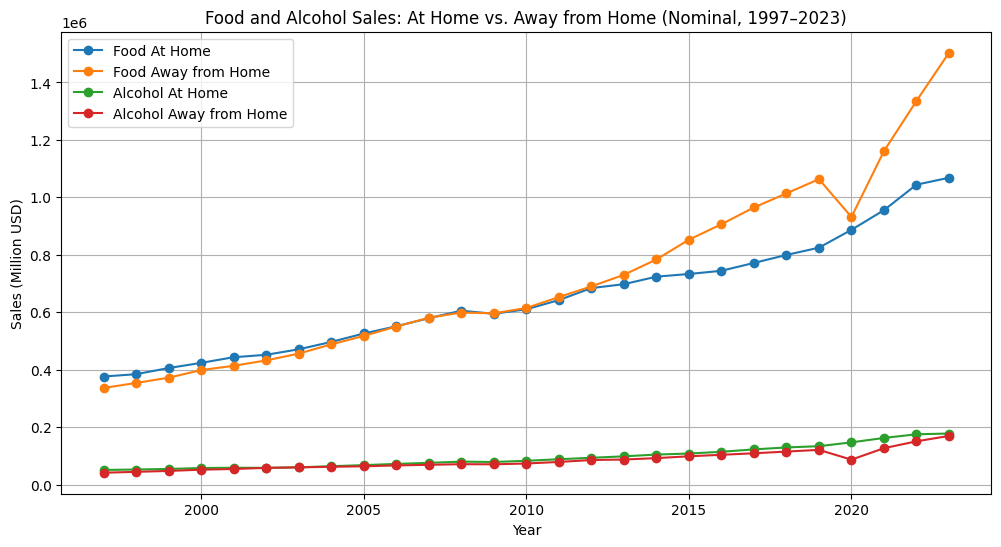

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Total_Food_At_Home_Sales_Nominal'], marker='o', label='Food At Home')
plt.plot(merged_df['Year'], merged_df['Total_Food_Away_Sales_Nominal'], marker='o', label='Food Away from Home')
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_At_Home_Sales_Nominal'], marker='o', label='Alcohol At Home')
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_Away_Sales_Nominal'], marker='o', label='Alcohol Away from Home')
plt.title('Food and Alcohol Sales: At Home vs. Away from Home (Nominal, 1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

- Food away from home sales grew significantly, especially post-2020, while food at home sales increased more steadily. 
- Alcohol sales (both at home and away) remained relatively flat, with a slight uptick in 2020, likely due to pandemic shifts.

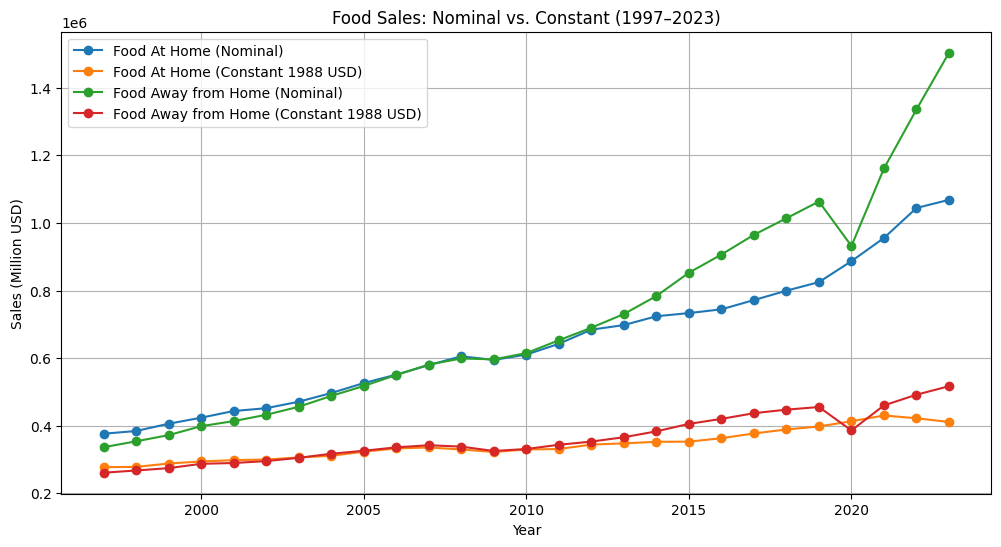

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Total_Food_At_Home_Sales_Nominal'], marker='o', label='Food At Home (Nominal)')
plt.plot(merged_df['Year'], merged_df['Total_Food_At_Home_Sales_Constant'], marker='o', label='Food At Home (Constant 1988 USD)')
plt.plot(merged_df['Year'], merged_df['Total_Food_Away_Sales_Nominal'], marker='o', label='Food Away from Home (Nominal)')
plt.plot(merged_df['Year'], merged_df['Total_Food_Away_Sales_Constant'], marker='o', label='Food Away from Home (Constant 1988 USD)')
plt.title('Food Sales: Nominal vs. Constant (1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

- Nominal food sales (at home and away) rose sharply, reflecting inflation. 
- Constant sales (1988 USD) grew more slowly, showing real spending increases were modest. 
- Dip in away home 2020 = pandemic impacts.

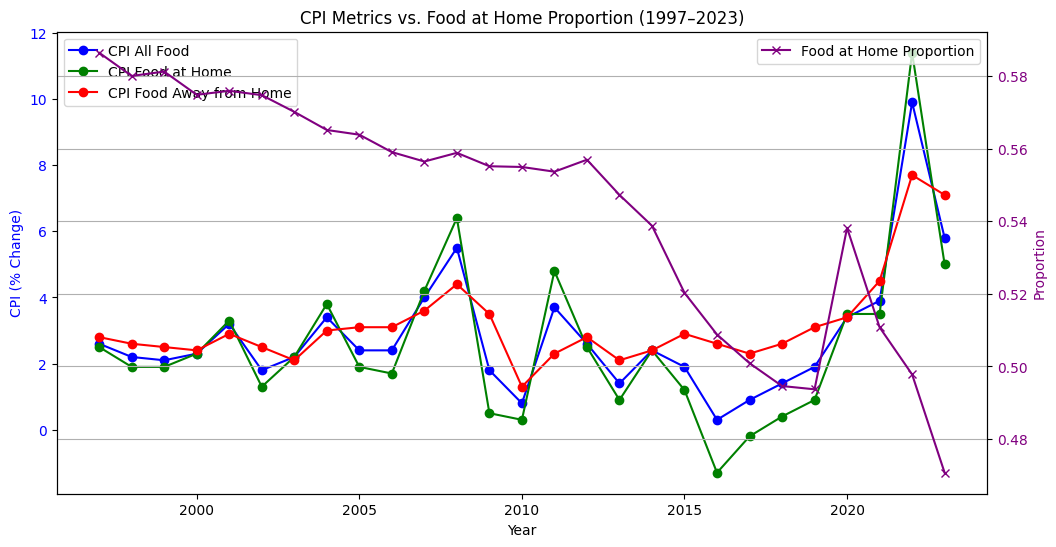

In [35]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# CPI on the left
ax1.plot(merged_df['Year'], merged_df['CPI_All_food'], marker='o', label='CPI All Food', color='blue')
ax1.plot(merged_df['Year'], merged_df['CPI_Food_at_home'], marker='o', label='CPI Food at Home', color='green')
ax1.plot(merged_df['Year'], merged_df['CPI_Food_away_from_home'], marker='o', label='CPI Food Away from Home', color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('CPI (% Change)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(merged_df['Year'], merged_df['Food_At_Home_Proportion'] / 100, marker='x', label='Food at Home Proportion', color='purple')
ax2.set_ylabel('Proportion', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

plt.title('CPI Metrics vs. Food at Home Proportion (1997–2023)')
plt.grid(True)
plt.show()

- The food at home proportion declined overall.
- CPI metrics fluctuated, with peaks in 2022 (CPI Food at Home at 11.4%). 
- No clear correlation exists between CPI and proportion.

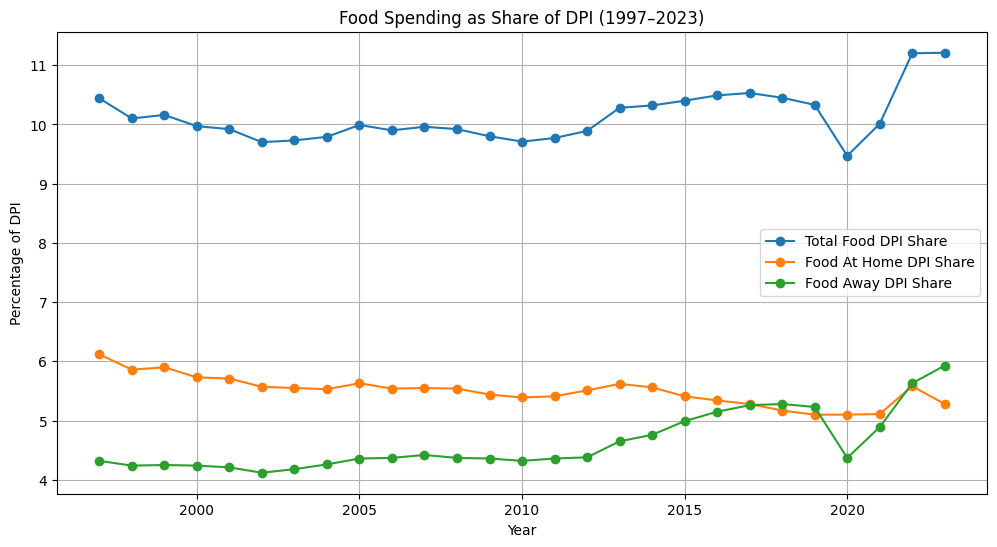

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Total_Food_DPI_Share'], marker='o', label='Total Food DPI Share')
plt.plot(merged_df['Year'], merged_df['Food_At_Home_DPI_Share'], marker='o', label='Food At Home DPI Share')
plt.plot(merged_df['Year'], merged_df['Food_Away_DPI_Share'], marker='o', label='Food Away DPI Share')
plt.title('Food Spending as Share of DPI (1997–2023)')
plt.xlabel('Year')
plt.ylabel('Percentage of DPI')
plt.legend()
plt.grid(True)
plt.show()

- The decline in DPI share despite rising nominal sales above suggests income growth outpaces food spending, except in 2020–2023.
- Inflation also plays a role in the 2023 increase.

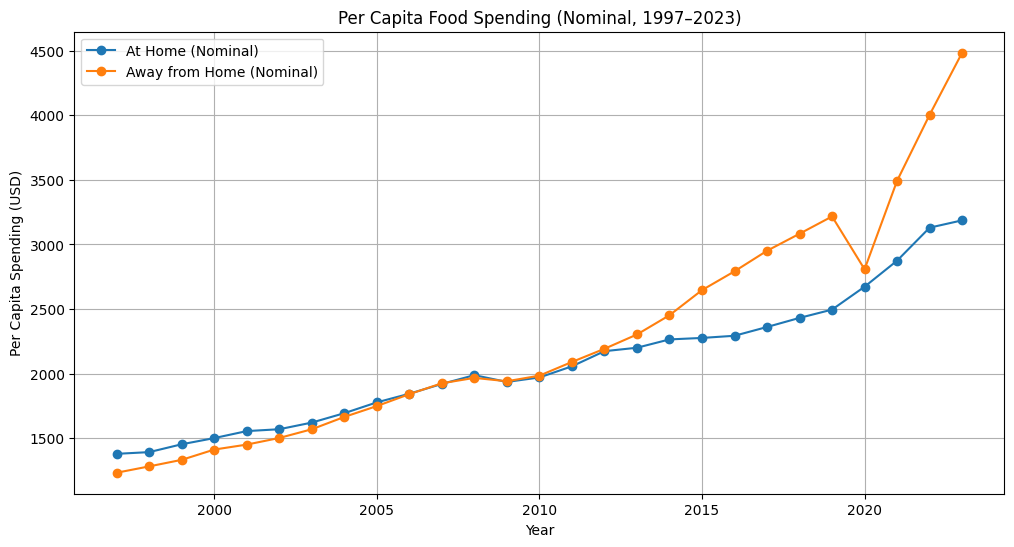

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Food_At_Home_Per_Capita_Nominal'], marker='o', label='At Home (Nominal)')
plt.plot(merged_df['Year'], merged_df['Food_Away_Per_Capita_Nominal'], marker='o', label='Away from Home (Nominal)')
plt.title('Per Capita Food Spending (Nominal, 1997–2023)')
plt.xlabel('Year')
plt.ylabel('Per Capita Spending (USD)')
plt.legend()
plt.grid(True)
plt.show()

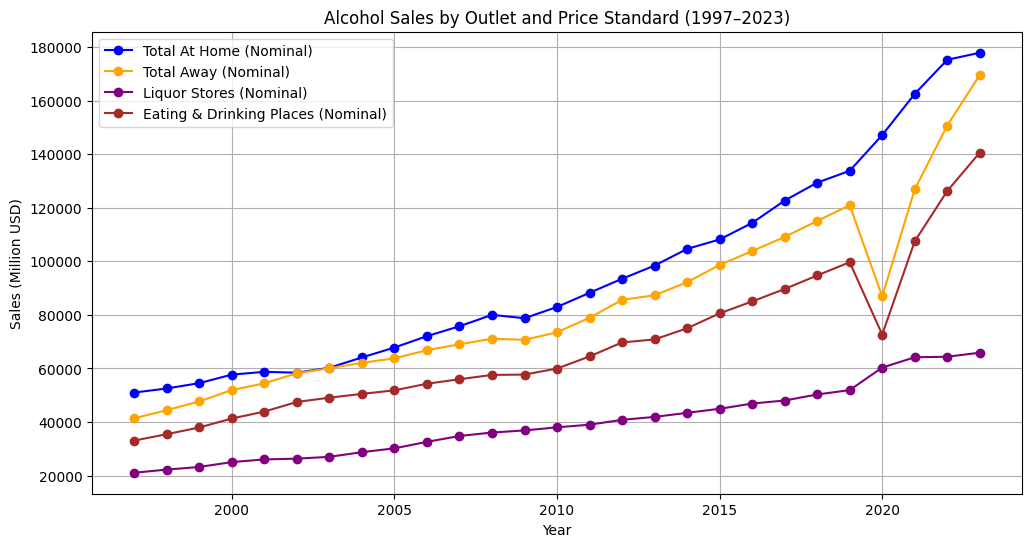

In [38]:
plt.figure(figsize=(12, 6))
# Total Alcohol Sales
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_At_Home_Sales_Nominal'], marker='o', label='Total At Home (Nominal)', color='blue')
plt.plot(merged_df['Year'], merged_df['Total_Alcohol_Away_Sales_Nominal'], marker='o', label='Total Away (Nominal)', color='orange')
# plt.plot(merged_df['Year'], merged_df['Total_Alcohol_At_Home_Sales_Constant'], marker='o', label='Total At Home (Constant 1988 USD)', color='green')
# plt.plot(merged_df['Year'], merged_df['Total_Alcohol_Away_Sales_Constant'], marker='o', label='Total Away (Constant 1988 USD)', color='red')
# Key Outlets (Nominal)
plt.plot(merged_df['Year'], merged_df['Liquor_Stores_Sales_Nominal'], marker='o', label='Liquor Stores (Nominal)', color='purple')
plt.plot(merged_df['Year'], merged_df['Eating_Drinking_Alcohol_Sales_Nominal'], marker='o', label='Eating & Drinking Places (Nominal)', color='brown')
plt.title('Alcohol Sales by Outlet and Price Standard (1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

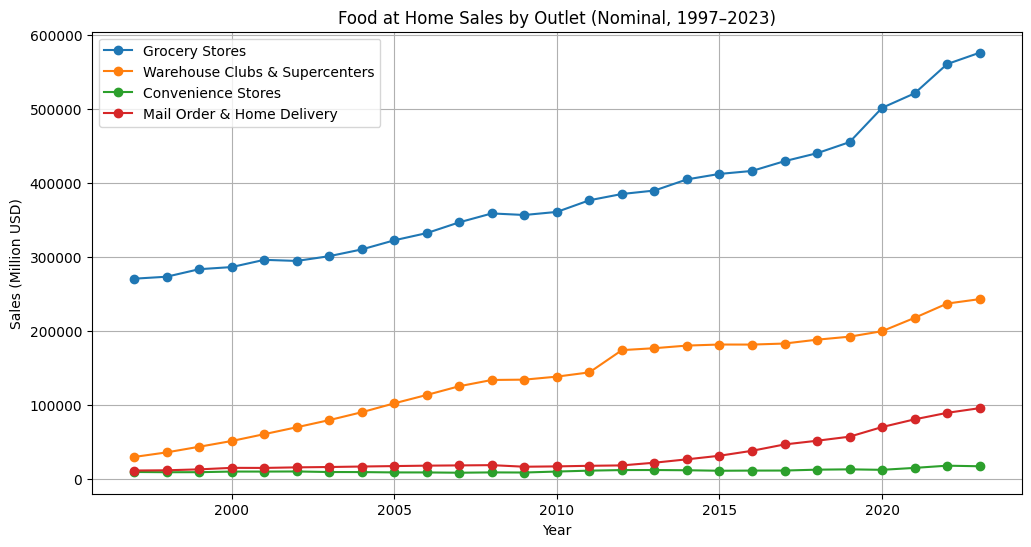

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['Grocery_Sales_Nominal'], marker='o', label='Grocery Stores')
plt.plot(merged_df['Year'], merged_df['Warehouse_Sales_Nominal'], marker='o', label='Warehouse Clubs & Supercenters')
plt.plot(merged_df['Year'], merged_df['Convenience_Sales_Nominal'], marker='o', label='Convenience Stores')
plt.plot(merged_df['Year'], merged_df['Mail_Order_Sales_Nominal'], marker='o', label='Mail Order & Home Delivery')
plt.title('Food at Home Sales by Outlet (Nominal, 1997–2023)')
plt.xlabel('Year')
plt.ylabel('Sales (Million USD)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
merged_df.keys()

Index(['Year', 'Grocery_Sales_Nominal', 'Convenience_Sales_Nominal',
       'Other_Food_Stores_Sales_Nominal', 'Warehouse_Sales_Nominal',
       'Other_Stores_Sales_Nominal', 'Mail_Order_Sales_Nominal',
       'Direct_Selling_Sales_Nominal', 'Home_Production_Sales_Nominal',
       'Total_Food_At_Home_Sales_Nominal',
       'Full_Service_Restaurants_Sales_Nominal',
       'Limited_Service_Restaurants_Sales_Nominal',
       'Drinking_Places_Sales_Nominal', 'Hotels_Motels_Sales_Nominal',
       'Retail_Vending_Sales_Nominal', 'Recreational_Places_Sales_Nominal',
       'Schools_Colleges_Sales_Nominal', 'Other_Food_Away_Sales_Nominal',
       'Food_Furnished_Donated_Sales_Nominal', 'Total_Food_Away_Sales_Nominal',
       'Liquor_Stores_Sales_Nominal', 'Food_Stores_Alcohol_Sales_Nominal',
       'Other_Alcohol_At_Home_Sales_Nominal',
       'Total_Alcohol_At_Home_Sales_Nominal',
       'Eating_Drinking_Alcohol_Sales_Nominal',
       'Hotels_Motels_Alcohol_Sales_Nominal',
       'Other_Alcoh

# Relativaty

Correlation with Food_At_Home_Proportion:
Food_At_Home_Proportion                1.000000
Median usual weekly real earnings     -0.762758
Total_Alcohol_At_Home_Sales_Nominal   -0.918818
Year                                  -0.921735
Name: Food_At_Home_Proportion, dtype: float64


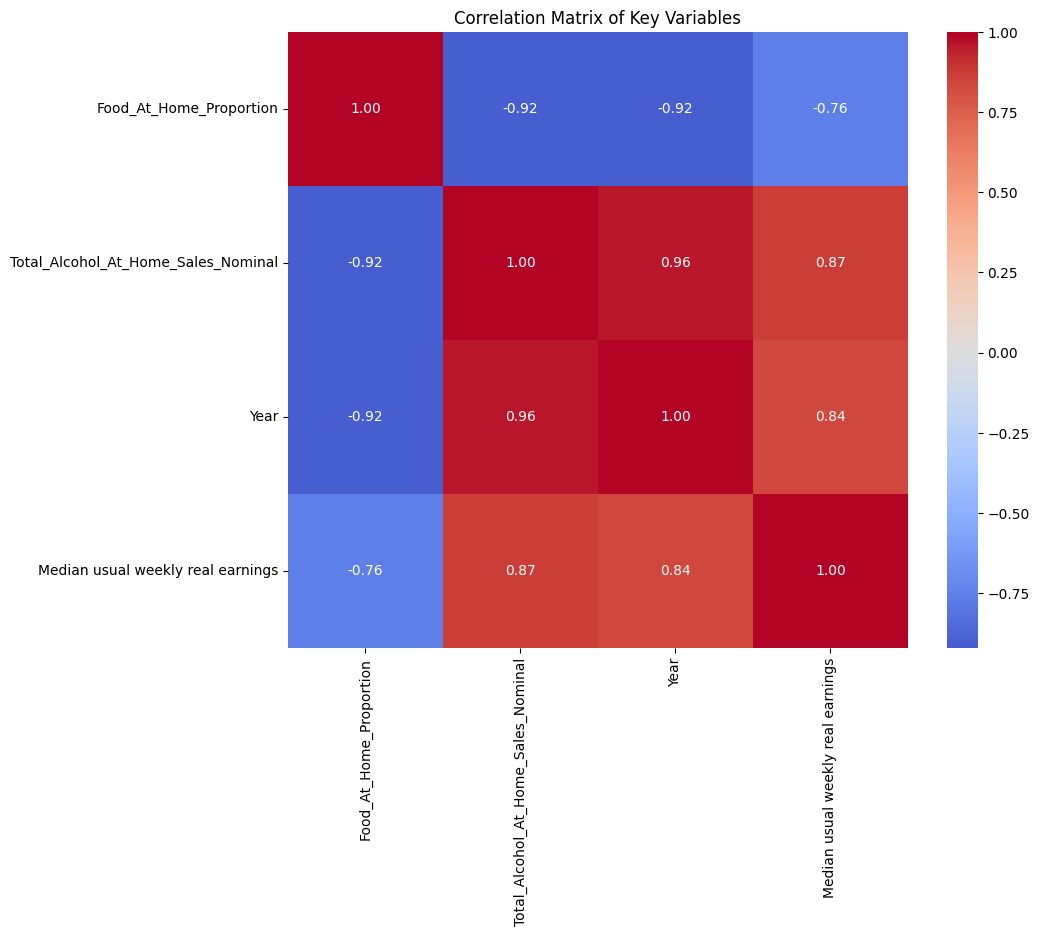

In [43]:
key_vars = [
    'Food_At_Home_Proportion',
    'Total_Alcohol_At_Home_Sales_Nominal',
    'Year', "Median usual weekly real earnings"
]

corr_matrix = merged_df[key_vars].corr()

print("Correlation with Food_At_Home_Proportion:")
print(corr_matrix['Food_At_Home_Proportion'].sort_values(ascending=False))


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Key Variables')
plt.show()

# Statistics Tests

### Model with 2 variables

In [430]:
predictors = ["Median usual weekly real earnings"]
X = merged_df[predictors].values
predictors.append("Year")
xmean = np.mean(X,  axis=0)
xstd = np.std(X, axis=0)
X = (X - xmean) / xstd
minyear = merged_df["Year"].min()
X = np.hstack((X, (merged_df["Year"] - minyear).values.reshape(-1, 1)))

y = merged_df['Food_At_Home_Proportion'].values / 100
n = len(y)

params, X, y, I = betareg.fit_regression(X, y)

-729.5561520046881
[ 0.09473553 -0.11626963  0.02614121  7.48896626] 4.954324681245211
[ 0.15382939 -0.16270223  0.02483617 12.42972889] 13.369280358607782
[ 0.19599482 -0.17642622  0.02312781 15.94043836] 17.044883708693533
[ 0.22932734 -0.17474135  0.02135115 18.6931913 ] 19.42673333419907
[ 2.56510398e-01 -1.66890092e-01  1.93156245e-02  2.13492768e+01] 21.38705827497739
[ 2.81399482e-01 -1.56560622e-01  1.79027244e-02  2.43642793e+01] 23.54725110692499
[ 3.02783721e-01 -1.46439788e-01  1.63424014e-02  2.75325617e+01] 25.468163494542864
[ 3.22825713e-01 -1.36449256e-01  1.50914972e-02  3.10716451e+01] 27.460595934063463
[ 3.40957502e-01 -1.27232113e-01  1.38138476e-02  3.48786280e+01] 29.337470483220898
[ 3.57758959e-01 -1.18633787e-01  1.26336157e-02  3.89582847e+01] 31.176527152818778
[ 3.73448636e-01 -1.10593959e-01  1.15636771e-02  4.33312654e+01] 32.9944355523362
[ 3.88040419e-01 -1.03123310e-01  1.05124762e-02  4.79670641e+01] 34.7572708485327
[ 4.01719627e-01 -9.61294239e-02 

In [431]:
n, p = X.shape
print(f"Condition number: {np.linalg.cond(I[:p, :p])}")
betareg.summary(params, predictors, X, y, I)

Condition number: 3004.5827579426295
Beta Regression Summary
Coefficient                         Value   Wald    P-value 
Intercept                           0.59    12.90   0.00    
Median usual weekly real earnings   0.00    0.04    0.97    
Year                                -0.00   -1.15   0.25    

Log-Likelihood:   77.14


### Year only model:

In [409]:
predictorsy = ["Year"]
Xy = merged_df[["Year"]].values
Xy = Xy - np.min(X)

paramsy, Xy, yy, Iy = betareg.fit_regression(Xy, y)

-729.5561520046881
[0.11593103 0.02174991 4.47255623] -5.558488185896003
[0.20630177 0.01684501 6.5774393 ] 2.525159770167285
[0.28187429 0.0125313  9.7605475 ] 9.562877350171519
[3.44104055e-01 9.11202366e-03 1.45381042e+01] 16.171092206225666
[3.94596145e-01 6.66837751e-03 2.11660721e+01] 22.62012607845162
[4.35022169e-01 4.67901468e-03 2.96598382e+01] 28.700350882755515
[4.67405471e-01 2.88947052e-03 3.97480922e+01] 34.27808775068115
[4.93112848e-01 1.58842756e-03 5.08928939e+01] 39.32034165800184
[5.13562252e-01 4.34816389e-04 6.25482974e+01] 43.64052869722343
[ 5.29757075e-01 -4.08042586e-04  7.42751157e+01] 47.294905859069445
[ 5.42627834e-01 -1.09047058e-03  8.57837863e+01] 50.29942221980241
[ 5.52878131e-01 -1.64404951e-03  9.68551454e+01] 52.7390525620317
[ 5.60984279e-01 -2.09451309e-03  1.07432260e+02] 54.707117903908966
[ 5.67438846e-01 -2.39567348e-03  1.17460733e+02] 56.32262622071312
[ 5.72584274e-01 -2.67650363e-03  1.26962111e+02] 57.63513293425626
[ 5.76647876e-01 -2.

In [426]:
n, p = Xy.shape
betareg.summary(paramsy, predictorsy, Xy, yy, Iy)

Beta Regression Summary
Coefficient   Value   Wald    P-value 
Intercept     0.59    21.29   0.00    
Year          -0.00   -2.05   0.04    

Log-Likelihood:   77.12


Year is significant by wald test in a model with no other predictors, let's check if the same is true for Median usual weekly earnings.

### Median usual weekly earnings only

In [ ]:
predictorsm = ["Median usual weekly real earnings"]
Xm = merged_df[predictors].values
xmmean = np.mean(Xm,  axis=0)
xmstd = np.std(Xm, axis=0)
Xm = (Xm - xmmean) / xmstd

paramsm, Xm, ym, Im = betareg.fit_regression(Xm, y)

-729.5561520046881
[ 5.43210417e-01 -2.38007381e-02  4.82329212e+01] 45.16460860287947
[ 5.43482694e-01 -2.39508060e-02  6.91419199e+01] 49.58665495624973
[ 5.43598973e-01 -2.40148834e-02  8.45308073e+01] 51.962753093716515
[ 5.43667904e-01 -2.40535143e-02  9.71739707e+01] 53.56359303365696
[ 5.43713694e-01 -2.40689633e-02  1.08092340e+02] 54.75660650624786
[ 5.43745404e-01 -2.40986356e-02  1.17797704e+02] 55.698950231801064
[ 5.43772548e-01 -2.41017376e-02  1.26590051e+02] 56.47219478104125
[ 5.43791141e-01 -2.41284806e-02  1.34663104e+02] 57.12402982930689
[ 5.43807442e-01 -2.41344010e-02  1.42150568e+02] 57.684693774915786
[ 5.43823137e-01 -2.41414484e-02  1.49149318e+02] 58.1745358474825
[ 5.43840073e-01 -2.41363006e-02  1.55732210e+02] 58.60788270529952
[ 5.43847170e-01 -2.41501761e-02  1.61955672e+02] 58.995191233940204
[ 5.43858769e-01 -2.41520419e-02  1.67864452e+02] 59.34431786108394
[ 5.43869587e-01 -2.41535623e-02  1.73494754e+02] 59.661308626825075
[ 5.43872146e-01 -2.41680

In [425]:
n, p = Xm.shape
betareg.summary(paramsm, predictorsm, Xm, ym, Im)

Beta Regression Summary
Coefficient                         Value   Wald    P-value 
Intercept                           0.54    28.48   0.00    
Median usual weekly real earnings   -0.02   -1.27   0.20    

Log-Likelihood:   65.84


Median usual weekly real earnings appears insignificant by wald test here, though it is significant by likelihood-ratio test.

### Null model for comparison

In [420]:
paramsn, Xn, yn, In = betareg.fit_regression(None, y)

-729.5561520046881
[ 0.54327066 46.36986691] 43.21173015108451
[ 0.5435558  65.23385412] 46.8207666747021
[ 0.54365812 78.61152534] 48.61849403735425
[ 0.54373014 89.27120127] 49.757246439902474
[ 0.54377911 98.23035529] 50.56090350644399
[  0.54381067 105.99848091] 51.16480855932173
[  0.5438434  112.87389807] 51.63776512283766
[  0.54385676 119.04905988] 52.01922520146377
[  0.54387035 124.6566329 ] 52.33375105028881
[  0.54388404 129.79265551] 52.59758378987385
[  0.5438952  134.52926327] 52.821965357362615
[  0.54390646 138.92227554] 53.01496683425603
[  0.54391788 143.01591324] 53.18255455771259
[  0.54392961 146.84590953] 53.32924800789965
[  0.54392961 150.44163344] 53.458541319917
[  0.54394162 153.82756141] 53.573186688480746
[  0.54394162 157.02432768] 53.675378038307144
[  0.54395384 160.0495581 ] 53.76689677236277
[  0.54395384 162.91839298] 53.84919608444625
[  0.54396375 165.64398862] 53.92348278223358
[  0.54396375 168.23786402] 53.99076160017512
[  0.54396375 170.710127

In [424]:
n, p = Xn.shape
betareg.summary(paramsn, [], Xn, yn, In)

Beta Regression Summary
Coefficient   Value   Wald    P-value 
Intercept     0.54    20.34   0.00    

Log-Likelihood:   54.67


I did not implement the score test anywhere

In [35]:
# Score Test (at beta = 0 for predictors)
beta_0 = np.zeros(num_p)
params_0 = np.concatenate([beta_0, [phi_hat]]) 
score_at_beta0 = score(params_0, X, y)[:-1] 
I_beta = -hessian(params_0, X, y)[:num_p, :num_p]
score_stat = score_at_beta0.T @ np.linalg.inv(I_beta) @ score_at_beta0
score_pval = chi2.sf(score_stat, df=num_p-1)
print("Score Test:", round(score_stat, 4), ", P-value:", round(score_pval, 4))

Score Test: -55.8447 , P-value: 1.0
